# Initialization

In [1]:
#------------------------------INITIALIZATION----------------------------------

from google.colab import drive
drive.mount('/content/gdrive')

!ls /content/gdrive/My\ Drive/Dora/Bilkent/CS464/HW3 # Use YOUR OWN DIRECTORY!!


import os
import csv
import math
import random
import operator
import pdb
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from timeit import default_timer as timer
from pylab import imshow,title,figure,show, gray
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC

np.random.seed(0)

root = '/content/gdrive/My Drive/Dora/Bilkent/CS464/HW3'

cancer_csv = os.path.join(root, 'breast_cancer.csv')
df_cancer = pd.read_csv(cancer_csv, header=0)

df_train = df_cancer.iloc[:500, :]
df_test = df_cancer.iloc[500:, :]

X = df_train.drop(['Class'], axis = 1) # We drop our "target" feature and use all the remaining features in our dataframe to train the model.
X.head()
y = df_train['Class']
y.head()

print()

Mounted at /content/gdrive
breast_cancer.csv  cs464_spring2021_hw3.ipynb  Q1.pdf  q2_dataset



## Performance Metrics Class

In [6]:
class Performance():
    def __init__(self, y_test, y_predict):
        
        true_positive = 0
        true_negative = 0
        false_positive = 0
        false_negative = 0

        for i in range(len(y_test)):
            if y_predict[i] == 1 and y_predict[i] == y_test[i] :
                true_positive += 1
            elif y_predict[i] == 0 and y_predict[i] == y_test[i] :
                true_negative += 1
            elif y_predict[i] == 1 and y_predict[i] != y_test[i] :
                false_positive += 1
            elif y_predict[i] == 0 and y_predict[i] != y_test[i] :
                false_negative += 1
        
        self.tp = true_positive
        self.tn = true_negative
        self.fp = false_positive
        self.fn = false_negative

        self.confusion_matrix = pd.DataFrame(np.array([[true_positive, false_positive], [false_negative, true_negative]]), 
                                             columns=['cancer diagnosis', 'no diagnosis'],
                                             index=['malignant tumor', 'benign tumor'])
        self.accuracy = (true_positive+true_negative)/(true_negative+true_positive+false_negative+false_positive)*100

    def calculate_all(self) :
        self.precision = self.tp / (self.tp + self.fp)*100
        self.recall = self.tp / (self.tp + self.fn)*100
        self.f1 = 2*self.precision * self.recall / (self.precision + self.recall) / 100
        beta = 2 
        self.f2 = (beta^2+1)*self.precision*self.recall/((beta^2)*self.precision + self.recall)/100  #beta f-measure with beta = 2, giving extra weight to recall
       
    def show(self, best_one = False):
        print('Number of True Positives: ', self.tp)
        print('Number of True Negatives: ', self.tn)
        print('Number of False Positives: ', self.fp)
        print('Number of False Negatives: ', self.fn)
        print('Accuracy is ', format(self.accuracy, '.4f'), ' %')
        
        if best_one :
            print('Precision is ', format(self.precision, '.4f'), '%')
            print('Recall is ', format(self.recall, '.4f'), '%')
            print('F1 measure is ', format(self.f1, '.4f'))
            print('F2 measure is ', format(self.f2, '.4f'))


# Question 1.1

For hyper-parameter c = 0.001 , 10-fold cross validation: 
Mean accuracy is = 56.0 %

For hyper-parameter c = 0.01 , 10-fold cross validation: 
Mean accuracy is = 93.0 %

For hyper-parameter c = 0.1 , 10-fold cross validation: 
Mean accuracy is = 89.0 %

For hyper-parameter c = 1 , 10-fold cross validation: 
Mean accuracy is = 91.0 %

For hyper-parameter c = 10 , 10-fold cross validation: 
Mean accuracy is = 89.0 %

For hyper-parameter c = 100 , 10-fold cross validation: 
Mean accuracy is = 88.0 %



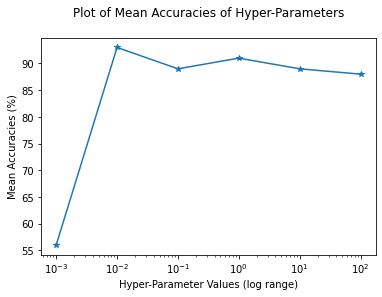


Highest accuracy is reached when hyper-parameter c = 0.01 , which is determined to be the best model.
 
When the best model is used on the test values, the following results are obtained: 
Number of True Positives:  44
Number of True Negatives:  154
Number of False Positives:  1
Number of False Negatives:  0
Accuracy is  99.4975  %
Precision is  97.7778 %
Recall is  100.0000 %
F1 measure is  0.9888
F2 measure is  0.9778



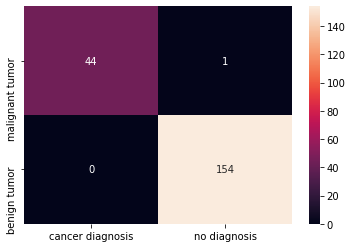

In [7]:
#------------------------------QUESTION 1.1------------------------------

#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report, confusion_matrix


def FastTrainSVM(X_train, y_train, X_test, c):
     X_train_min = X_train.min()
     X_train_max = X_train.max()
     X_train_range = (X_train_max - X_train_min)

     X_train_scaled = (X_train - X_train_min)/(X_train_range)
     X_train_scaled.head()

     X_test_min = X_test.min()
     X_test_range = (X_test - X_test_min).max()
     X_test_scaled = (X_test - X_test_min)/X_test_range

     svc_model = SVC(C = c)
     svc_model.fit(X_train_scaled, y_train)

     y_predict = svc_model.predict(X_test_scaled)
     return(y_predict)

parameters = [0.001, 0.01, 0.1, 1, 10, 100]
mean_acc = []
optC_index = 0
k = 10 # number of folds

for p, c in enumerate(parameters):
    print('For hyper-parameter c =', c, ', 10-fold cross validation: ')
    cross_acc = []

    for i in range(k):
        
        X_train = X.drop(range(k*i, k*(i+1)), axis = 0 ) # training features without validation
        y_train =  y.drop(range(k*i, k*(i+1)), axis = 0 ) # training labels without validation

        X_valid = X.iloc[k*i : k*(i+1), :] # validation features
        y_valid = y[k*i : k*(i+1)] # validation labels
        
        y_predict = FastTrainSVM(X_train, y_train, X_valid, c)
        prf = Performance(y_valid.to_numpy(), y_predict)
        acc = prf.accuracy
        #print('fold:', i, ', Accuracy =', acc, '%')
        cross_acc = np.append(cross_acc, acc)
    
    mean_acc = np.append(mean_acc, cross_acc.mean()) 
    print('Mean accuracy is =', mean_acc[p], '%\n')

    if mean_acc[p] > mean_acc[optC_index] :
        optC_index = p

optC = parameters[optC_index]
plt.semilogx(parameters, mean_acc, '*-')
plt.title("Plot of Mean Accuracies of Hyper-Parameters\n")
plt.ylabel('Mean Accuracies (%)')
plt.xlabel('Hyper-Parameter Values (log range)')
plt.show()

print('\nHighest accuracy is reached when hyper-parameter c =', optC, ', which is determined to be the best model.\n', '\nWhen the best model is used on the test values, the following results are obtained: ' )        

X_test = df_test.drop(['Class'], axis = 1) # We drop our "target" feature and use all the remaining features in our dataframe to train the model.
X_test.head()
y_test = df_test['Class']
y_test.head()

y_testpredict = FastTrainSVM(X, y, X_test, optC)
testprf = Performance(y_test.to_numpy(), y_testpredict)
testprf.calculate_all()
cm = testprf.confusion_matrix

testprf.show(best_one = True)
sns.heatmap(cm, annot=True, fmt="d")

print()


# Question 1.2


For hyper-parameter c = 0.001
For gamma = 0.0002 , 10-fold cross validation: 
Mean accuracy is = 56.0 %
For gamma = 0.002 , 10-fold cross validation: 
Mean accuracy is = 56.0 %
For gamma = 0.02 , 10-fold cross validation: 
Mean accuracy is = 56.0 %
For gamma = 2.0 , 10-fold cross validation: 
Mean accuracy is = 56.0 %
For gamma = 20.0 , 10-fold cross validation: 
Mean accuracy is = 56.0 %

For hyper-parameter c = 0.01
For gamma = 0.0002 , 10-fold cross validation: 
Mean accuracy is = 56.0 %
For gamma = 0.002 , 10-fold cross validation: 
Mean accuracy is = 56.0 %
For gamma = 0.02 , 10-fold cross validation: 
Mean accuracy is = 56.0 %
For gamma = 2.0 , 10-fold cross validation: 
Mean accuracy is = 92.0 %
For gamma = 20.0 , 10-fold cross validation: 
Mean accuracy is = 56.0 %

For hyper-parameter c = 0.1
For gamma = 0.0002 , 10-fold cross validation: 
Mean accuracy is = 56.0 %
For gamma = 0.002 , 10-fold cross validation: 
Mean accuracy is = 56.0 %
For gamma = 0.02 , 10-fold cross valida

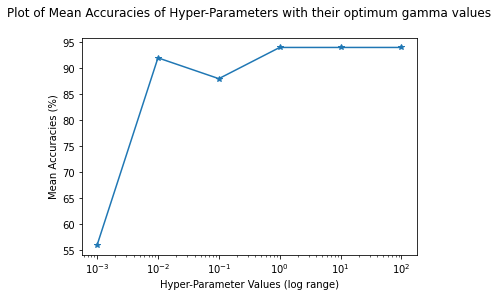


Highest accuracy is reached when hyper-parameter c = 1 and gamma = 0.02 , which is determined to be the best model.
 
When the best model is used on the test values, the following results are obtained: 
Number of True Positives:  44
Number of True Negatives:  154
Number of False Positives:  1
Number of False Negatives:  0
Accuracy is  99.4975  %
Precision is  97.7778 %
Recall is  100.0000 %
F1 measure is  0.9888
F2 measure is  0.9778



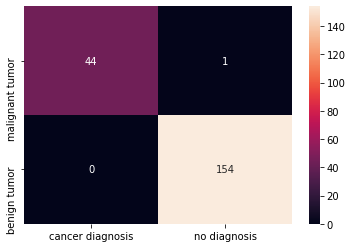

In [8]:
#------------------------------QUESTION 1.2------------------------------

def FastTrainRBF(X_train, y_train, X_test, c, gamma_svm):
     X_train_min = X_train.min()
     X_train_max = X_train.max()
     X_train_range = (X_train_max - X_train_min)

     X_train_scaled = (X_train - X_train_min)/(X_train_range)
     X_train_scaled.head()

     X_test_min = X_test.min()
     X_test_range = (X_test - X_test_min).max()
     X_test_scaled = (X_test - X_test_min)/X_test_range

     svm_model = SVC(C = c ,  gamma = gamma_svm)
     svm_model.fit(X_train_scaled, y_train)

     y_predict = svm_model.predict(X_test_scaled)
     return(y_predict)


optC_index = 0
optG_index = 0
optg_list = np.array([])
optg_acclist = np.array([])
    
parameters = [0.001, 0.01, 0.1, 1, 10, 100]
gamma_range = [2e-4, 2e-3, 2e-2, 2e0, 2e1]

k_num = 10 # number of folds

for p, c in enumerate(parameters):
    print('\nFor hyper-parameter c =', c)
    mean_acc_gamma = []
    optg_index_temp = 0


    for g, gamma in enumerate(gamma_range):
        print('For gamma =', gamma, ', 10-fold cross validation: ')
        cross_acc = []
        
        for k in range(k_num):
                
            X_train = X.drop(range(k_num*k, k_num*(k+1)), axis = 0 ) # training features without validation
            y_train =  y.drop(range(k_num*k, k_num*(k+1)), axis = 0 ) # training labels without validation

            X_valid = X.iloc[k_num*k : k_num*(k+1), :] # validation features
            y_valid = y[k_num*k : k_num*(k+1)] # validation labels
            
            y_predict = FastTrainRBF(X_train, y_train, X_valid, c, gamma)
            prf = Performance(y_valid.to_numpy(), y_predict)
            acc = prf.accuracy
            #print('fold:', k, 'gamma = ', gamma, ', Accuracy =', acc, '%')        
            cross_acc = np.append(cross_acc, acc)

        mean_acc_gamma = np.append(mean_acc_gamma, cross_acc.mean()) 
        print('Mean accuracy is =', mean_acc_gamma[g], '%')

        if mean_acc_gamma[g] > mean_acc_gamma[optg_index_temp] :
            optg_index_temp = g

    optg_list = np.append(optg_list, gamma_range[optg_index_temp])
    optg_acclist = np.append(optg_acclist, mean_acc_gamma[optg_index_temp])
    
    if optg_acclist[p] > optg_acclist[optG_index] :
        optG_index = p
        optC_index = p

optC = parameters[optC_index]
optG = optg_list[optG_index]

plt.semilogx(parameters, optg_acclist, '*-')
plt.title("Plot of Mean Accuracies of Hyper-Parameters with their optimum gamma values\n")
plt.ylabel('Mean Accuracies (%)')
plt.xlabel('Hyper-Parameter Values (log range)')
plt.show()

print('\nHighest accuracy is reached when hyper-parameter c =', optC, 'and gamma =', optG, ', which is determined to be the best model.\n', '\nWhen the best model is used on the test values, the following results are obtained: ' )        

X_test = df_test.drop(['Class'], axis = 1) # We drop our "target" feature and use all the remaining features in our dataframe to train the model.
X_test.head()
y_test = df_test['Class']
y_test.head()

y_testpredict = FastTrainRBF(X, y, X_test, optC, optG)
testprf = Performance(y_test.to_numpy(), y_testpredict)
testprf.calculate_all()
cm = testprf.confusion_matrix

testprf.show(best_one = True)
sns.heatmap(cm, annot=True, fmt="d")

print()
